# Imports

Links to Google Colab containing other claim spotting models can be found below:


*   [Transformer/BERT-based](https://colab.research.google.com/github/idirlab/claimspotter/blob/master/adv_transformer/adv_transformer-notebook.ipynb)
*   [BiLSTM](https://colab.research.google.com/github/idirlab/claimspotter/blob/master/bidirectional_lstm/bilstm-notebook.ipynb)

Load imports and define which parts of speech we will use as features in the model.

In [ ]:
# Copyright (C) 2020 IDIR Lab - UT Arlington
#
#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License v3 as published by
#     the Free Software Foundation.
#
#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#     GNU General Public License for more details.
#
#     You should have received a copy of the GNU General Public License
#     along with this program.  If not, see <https://www.gnu.org/licenses/>.
#
# Contact Information:
#     See: https://idir.uta.edu/cli.html
#
#     Chengkai Li
#     Box 19015
#     Arlington, TX 76019
#

import csv
import json
import math
import os
import pickle
import joblib
import nltk
import numpy as np
import pandas as pd
import sklearn.metrics as mt
import matplotlib.pyplot as plt
from shutil import rmtree
from copy import deepcopy
from itertools import chain
from itertools import product
from nltk import pos_tag
from nltk import word_tokenize
from numpy import argmax, interp, random
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from sklearn.neighbors import KernelDensity


POS = [
    'MD', 'VBN', 'PRP$', 'CD', 'NNS', 'RBR', 'LS', 'WP', 'JJR', 'RB', 'WP$', 'VBZ', '-LRB-', 'CC', 'JJ', 
    '$', ':', 'VBG', "''", ',', 'WDT', 'EX', 'PDT', 'RP', '``', 'NNPS', 'NNP', 'FW', 'VB', 'PRP', 'RBS', 
    'DT', 'WRB', 'NN', '.', '-NONE-', 'IN', 'TO', 'UH', 'VBD', 'POS', 'VBP', 'JJS', 'SYM', '(', ')'
]

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Helper Functions

## Metrics Functions
Define helper functions to compute metrics.

In [ ]:
def compute_kde(x):
    # https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
    x = np.asarray(x).reshape(-1, 1)
    X_plot = np.linspace(0, 1, len(x))[:, np.newaxis]
    fig, ax = plt.subplots()
    colors = ['darkorange']
    kernels = ['gaussian']
    lw = 15

    for color, kernel in zip(colors, kernels):
        kde = KernelDensity(kernel=kernel, bandwidth=0.10).fit(x)
        log_dens = kde.score_samples(X_plot)
        ax.plot(X_plot[:, 0], np.exp(log_dens), color=color, lw=lw, linestyle='-')

    ax.legend().remove()
    ax.plot(x[:, 0], -0.005 - 0.01 * random.random(x.shape[0]), '+k', markersize=lw)

    ax.set_xlim(0, 1)
    ax.set_ylim(-0.06, 1.75)
    plt.show()

def compute_precisions(labels, scores, cutoff=None):
    # https://github.com/apepa/clef2019-factchecking-task1/blob/master/scorer/task1.py#L81
    combined = sorted([(scores[i], labels[i]) for i in range(len(scores))], reverse=True)
    cutoff = min(cutoff or math.inf, len(combined))
    combined = combined[:cutoff]
    precisions = [0.0] * cutoff

    for i, x in enumerate(combined):
        if x[1] == 1:
            precisions[i] += 1.0

    for i in range(1, cutoff): # accumulate
        precisions[i] += precisions[i - 1]
    for i in range(1, cutoff): # normalize
        precisions[i] /= i+1

    return precisions


def compute_average_precision(labels, scores, cutoff=None):
    # https://github.com/apepa/clef2019-factchecking-task1/blob/master/scorer/task1.py#L52
    combined = sorted([(scores[i], labels[i]) for i in range(len(scores))], reverse=True)
    cutoff = min(cutoff or math.inf, len(combined))
    combined = combined[:cutoff]
    labels = [x[1] for x in combined]
    precisions = []
    num_correct = 0
    num_positive = sum(labels)

    for i, x in enumerate(combined):
        if x[1] == 1:
            num_correct += 1
            precisions.append(num_correct / (i + 1))
    
    if precisions:
        avg_prec = sum(precisions) / num_positive
    else:
        avg_prec = 0.0

    return avg_prec

def compute_dcg_term(i, labels, ver=1):
    # Difference between version 0 and 1: https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Discounted_Cumulative_Gain
    return labels[i - 1] / math.log2(i + 1) if ver == 0 else ((1 << labels[i - 1]) - 1) / math.log2(i + 1)


def compute_ndcg(labels, scores, cutoff=None):
    # Precondition: for each index i, scores[i] corresponds with labels[i]
    ver = 0
    combined = sorted([(scores[i], labels[i]) for i in range(len(scores))], reverse=True)
    cutoff = min(cutoff or math.inf, len(combined))
    combined = combined[:cutoff]
    labels = [x[1] for x in combined]

    dcg = sum([compute_dcg_term(i, labels, ver=ver) for i in range(1, len(labels) + 1, 1)])
    ideal_labels = sorted(labels, reverse=True)
    idcg = sum([compute_dcg_term(i, ideal_labels, ver=ver) for i in range(1, len(labels) + 1, 1)])

    try:
        return dcg / idcg
    except ZeroDivisionError:
        return dcg / 0.0000000000001

## Feature Vector Functions
Helper functions to generate different parts of feature vector.

In [ ]:
def get_ngram(file_name, tf_idf_vect, data, n, store_vocab=False, set_index=None):
    sentence_term_tfidf = tf_idf_vect.transform(data.text)
    sentence_term_df = pd.DataFrame(sentence_term_tfidf.todense(), columns=np.sort(list(tf_idf_vect.vocabulary_.keys())))

    if set_index is not None:
        sentence_term_df = sentence_term_df.set_index(set_index)

    if store_vocab:
        pd.DataFrame(sentence_term_df.columns).to_csv("models/vocabulary_" + file_name + ".txt", encoding='utf-8', index=False)

    sentence_term_df.columns = sentence_term_df.columns.map(lambda x: 'W_' + str(n) + '_' + x)

    return sentence_term_df


def get_pos(data, n):
    POSn = {x: 0 for x in product(POS, repeat=n)}
    data_pos = pd.DataFrame(columns=POSn.keys())
    data_pos.columns = data_pos.columns.map(lambda x: 'P_' + str(n) + '_' + '_'.join(x))

    for idx, r in data.iterrows():
        POSn = {x: 0 for x in product(POS, repeat=n)}
        token_pos = pos_tag(word_tokenize(r.text))
        token_pos = [y for (x, y) in token_pos]
        token_pos = zip(*[token_pos[i:] for i in range(n)])

        for tp in token_pos:
            POSn[tp] += 1

        data_pos.loc[idx] = list(POSn.values())
    return data_pos

## Training and Cross Validation Functions
Functions to train the final model and perform k-fold cross validation on the dataset.

In [ ]:
def train_models(file_name, data, clfs, features, labels):
    models = []

    for feature_regex, feature_types in features:
        for clf, name in clfs:
            # Prepare training data with appropriate feature set
            train_filter_regex = data.filter(regex=feature_regex)
            train_filter_regex = train_filter_regex.sort_index(axis=1)

            # Train and save the model for later use
            clf.fit(train_filter_regex, data[labels])
            j = joblib.dump(clf, 'models/' + name + '_' + feature_types + '_' + file_name + '.pkl')

            models += [(name, (feature_regex, feature_types), clf)]

            print("[" + file_name + "] " + "Training " + name + '_' + feature_types + " complete.\n")
    return models


@ignore_warnings(category=UndefinedMetricWarning)
@ignore_warnings(category=ConvergenceWarning)
def evaluate(file_name, data, clfs, features, labels, num_folds, num_classes=2):
    print("K-folds total samples: ", len(data))
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2)
    fold_count = 1

    # ROC plot reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    for feature_regex, _feature_types in features:
        for clf, clf_name in clfs:
            cm = np.zeros((num_classes, num_classes)) 
            avg_ndcg = 0
            avg_balanced_accuracy = 0
            avg_ap = 0
            aggregated_labels = []
            aggregated_predictions = []
            tprs = []
            aucs = []
            mean_fpr = np.linspace(0, 1, 100)
            fig, ax = plt.subplots()

            for train_index, test_index in kf.split(data, data[labels]):
                # Mask data for the given fold
                train = data.iloc[train_index]
                test = data.iloc[test_index]

                # Learn vocabulary and idf for the training data
                fold_tf_idf_vect = TfidfVectorizer(min_df=1, ngram_range=(n_gram, n_gram))
                fold_tf_idf_vect.fit(train.text)

                # Vectorize training data
                train = pd.concat([train, get_ngram(file_name, fold_tf_idf_vect, train, 1, set_index=train_index)], axis=1)
                train = pd.concat([train, get_pos(train, 1)], axis=1)

                # Vectorize testing data
                test = pd.concat([test, get_ngram(file_name, fold_tf_idf_vect, test, 1, set_index=test_index)], axis=1)
                test = pd.concat([test, get_pos(test, 1)], axis=1)

                print("Fold: {0}, Training Samples: {1}, Testing Samples: {2}".format(fold_count, len(train), len(test)))

                # Train the model for this fold
                train_filter_regex = train.filter(regex=feature_regex)
                train_filter_regex = train_filter_regex.sort_index(axis=1)
                clf.fit(train_filter_regex, train[labels])

                # Evaluate the model for this fold
                test_filter_regex = test.filter(regex=feature_regex)
                test_filter_regex = test_filter_regex.sort_index(axis=1)
                predictions = clf.predict(test_filter_regex)

                fold_labels_list = test[labels].tolist()

                # Aggreate some ROC metrics
                viz = mt.plot_roc_curve(clf, test_filter_regex, test[labels], name='ROC fold {}'.format(fold_count), alpha=0.3, lw=1, ax=ax)
                interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                aucs.append(viz.roc_auc)

                # Aggregate fold results to generate an aggregated report at the end
                aggregated_labels += fold_labels_list
                aggregated_predictions += predictions.tolist()

                cfs_scores = [x[1] for x in clf._predict_proba_lr(test_filter_regex).tolist()]

                ndcg = compute_ndcg(fold_labels_list, cfs_scores)
                avg_ndcg += ndcg

                balanced_accuracy = mt.balanced_accuracy_score(test[labels], predictions)
                avg_balanced_accuracy += balanced_accuracy

                average_precision = compute_average_precision(fold_labels_list, cfs_scores)
                avg_ap += average_precision

                print('########## Classification Report ##########')
                print(mt.classification_report(test[labels], predictions, digits=4))
                
                print('############ Confusion Matrix #############')
                print(mt.confusion_matrix(test[labels], predictions), "\n")

                print("nDCG Score: ", ndcg)
                print("Average Precision: ", average_precision)
                print("Balanced Accuracy: ", balanced_accuracy, "\n")
                print("# --------------------------------------------------------- #\n")

                cm += mt.confusion_matrix(test[labels], predictions)
                fold_count += 1

            print('# Aggregated K-Fold Classification Report #')
            print(mt.classification_report(aggregated_labels, aggregated_predictions, digits=4))

            print('### Aggregated K-Fold Confusion Matrix ####')
            print(cm, "\n")

            print("Average nDCG: ", avg_ndcg / num_folds)
            print("Mean Average Precision: ", avg_ap / num_folds)
            print("Average Balanced Accuracy: ", avg_balanced_accuracy / num_folds, "\n")
            print("# --------------------------------------------------------- #\n")

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = mt.auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

            ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="[{0}] {1} ROC".format(file_name, clf_name))
            ax.legend(loc="lower right")
            plt.show()

## Load Trained Model Function
Define function to load the trained model and score sentences using it.

In [ ]:
def getCFSScore(file_name=None, transcript="", models=[("SVM", ("length|W_|P_", "W_P"), None)]):
    def get_pos_vector(text):
        dict_pos_count = {k: 0 for k in POS}
        pos_tags = pos_tag(word_tokenize(text))  # TextBlob(text).pos_tags#

        for _, tag in pos_tags:
            if tag in dict_pos_count.keys():
                dict_pos_count[tag] += 1

        return dict_pos_count

    # Load in the vocabulary and pre-calculated idf
    vocabulary = pd.read_csv(os.path.join('models', 'vocabulary_{0}.txt'.format(file_name)))
    count_vect = CountVectorizer(vocabulary=vocabulary['0'])
    idf_ = pickle.load(open(os.path.join('models', 'idf_{0}'.format(file_name)), 'rb'))

    # Convert sentence to dataframe and back up original text before vectorization
    sentences = [transcript]
    sentences = pd.DataFrame(sentences)
    sentences.columns = ['text']
    sentences['original_text'] = sentences.text
    sentences.text = sentences['original_text'].map(lambda s: s.lower())
    sentences['sentence_id'] = sentences.index

    # Vectorize the sentence
    sentence_word = count_vect.fit_transform(sentences.text)
    sentence_word = sentence_word.toarray() * idf_
    sentence_word = normalize(sentence_word, axis=1, norm='l2')
    sentence_word = pd.DataFrame(sentence_word, columns=vocabulary['0'])
    sentence_word = pd.concat([sentences.sentence_id, sentence_word], axis=1)
    sentence_word = sentence_word.set_index('sentence_id')
    sentence_word.columns = sentence_word.columns.map(lambda x: 'W_1_' + str(x))

    # Get the part of speech vector for the sentence
    sentence_pos = {sentences.sentence_id[i]: get_pos_vector(sentences.text[i]) for i in sentences.index}
    sentence_pos = pd.DataFrame(sentence_pos).T
    sentence_pos.columns = sentence_pos.columns.map(lambda x: 'P_1_' + str(x))
    sentence_pos.index.names = ['sentence_id']

    # Append sentence length info as a feature
    sentence_pos['length'] = [len(sentences.loc[id].text.split()) for id in sentences.index]

    # Concatenate all the features into one dataframe
    data = pd.concat([sentence_pos, sentence_word], axis=1)

    # Load in the models and return class prediction probabilities for the input sentence
    for name, (feature_regex, feature_types), clf in models:
        clf = joblib.load('models/' + name + '_' + feature_types + '_' + file_name + '.pkl')
        model_name = clf.__class__.__name__
        data_regex = data.filter(regex=feature_regex)
        data_regex = data_regex.sort_index(axis=1)

        if str(model_name) == 'LinearSVC':
            return clf._predict_proba_lr(data_regex)[0]
        else:
            return clf.predict_proba(data_regex)[0]


# Get Data and Set Training Options

Download the necessary data.

In [ ]:
!wget -O claimbuster_dataset.json https://github.com/idirlab/claimspotter/raw/master/data/two_class/kfold_25ncs.json
!wget -O clef_dataset.tsv https://github.com/idirlab/claimspotter/raw/master/data/clef19/CT19-T1-Training.csv
!wget -O clef_test.tsv https://github.com/idirlab/claimspotter/raw/master/data/clef19/CT19-T1-Test.csv

--2021-02-09 17:55:00--  https://github.com/idirlab/claimspotter/raw/master/data/two_class/kfold_25ncs.json
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/idirlab/claimspotter/master/data/two_class/kfold_25ncs.json [following]
--2021-02-09 17:55:01--  https://raw.githubusercontent.com/idirlab/claimspotter/master/data/two_class/kfold_25ncs.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1600093 (1.5M) [text/plain]
Saving to: ‘claimbuster_dataset.json’

claimbuster_dataset 100%[===================>]   1.53M  --.-KB/s    in 0.06s   

2021-02-09 17:55:01 (24.2 MB/s) - ‘claimbuster_dataset.json’ sav

The main code to train, perform k-fold cross validation, and post-training evaluation.

There are 4 pre-defined training options defined in the `training_options` dictionary:

1.   `train_claimbuster_no_test`: Train the model on the ClaimBuster dataset and only do k-fold cross validation. No post training evaluation on a separate test set is performed.
2.   `train_claimbuster_test_clef`: Train the model on the ClaimBuster dataset, do k-fold cross validation, and perform post training evaluation on the CLEF-2019 test dataset.
3.   `train_clef_no_test`: Train the model on the CLEF-2019 dataset and only do k-fold cross validation. No post training evaluation on a separate test set is performed.
4.   `train_clef_test_clef`: Train the model on the CLEF-2019 dataset, do k-fold cross validation, and perform post training evaluation on the CLEF-2019 test dataset.


In [ ]:
training_options = {
    "train_claimbuster_no_test": (100000000, 1000, "claimbuster_dataset", "json", "", "\t", "utf-8", "utf-8", True, False, 1, 4, True),
    "train_claimbuster_test_clef": (100000000, 1000, "claimbuster_dataset", "json", "./clef_test.tsv", "\t", "utf-8", "utf-8", True, True, 1, 4, True),
    "train_clef_no_test": (100000000, 1000, "clef_dataset", "tsv", "", "\t", "utf-8", "utf-8", True, False, 1, 4, True),
    "train_clef_test_clef": (100000000, 1000, "clef_dataset", "tsv", "./clef_test.tsv", "\t", "utf-8", "utf-8", True, True, 1, 4, True)
}

(max_num_iters, max_num_iters_kfold, train_file_name, train_file_ext, 
test_file_path, csv_delimiter, train_file_encoding, test_file_encoding, 
test_file_has_header, test_file_in_multiple_doc_order, n_gram, num_folds, 
train_new_model) = training_options["train_clef_test_clef"]

# Train Model and Perform K-Fold Cross Validation

Train the model using the training option defined above.

In [ ]:
# Reset models dir
rmtree("./models", ignore_errors=True)
os.makedirs("models", exist_ok=False)

if train_new_model:
    # Load the data and shuffle it
    if train_file_ext in ["csv", "tsv"]:
        data = pd.read_csv(f"./{train_file_name}.{train_file_ext}", encoding=train_file_encoding, delimiter=",", quotechar='"')
    elif train_file_ext in ["json"]:
        pd.read_json(f"./{train_file_name}.{train_file_ext}", encoding=train_file_encoding)
    data = data.sample(frac=1).reset_index(drop=True)

    # Create a global tf_idf vectorizer with entire vocabulary
    final_tf_idf_vect = TfidfVectorizer(min_df=1, ngram_range=(n_gram, n_gram))
    final_tf_idf_vect.fit(data.text)
    pickle.dump(final_tf_idf_vect.idf_, open("models/idf_" + train_file_name, "wb"))

    # Add in sentence length info to dataframe
    sen_len = pd.DataFrame()
    sen_len['length'] = [len(data.loc[id].text.split()) for id in data.index]
    data = pd.concat([data, sen_len], axis=1)

    # Vectorize final data for training the final model and storing for loading the model post training
    final_data = pd.concat([data, get_ngram(train_file_name, final_tf_idf_vect, data, n_gram, True)], axis=1)

    # Get PoS feature set for final data
    final_data = pd.concat([final_data, get_pos(final_data, 1)], axis=1)

    # Store final data in pickle files
    j = joblib.dump(final_data, './models/DF_' + train_file_name + '.pkl')
    final_data = joblib.load('./models/DF_' + train_file_name + '.pkl')

    # Train the classifiers
    classifiers = {
        "final_model": [(LinearSVC(max_iter=max_num_iters), "SVM")],
        "k_fold_models": [(LinearSVC(max_iter=max_num_iters_kfold), "SVM")]
        }
    features = [('length|W_|P_', 'W_P')]
    models = train_models(train_file_name, final_data, classifiers["final_model"], features, 'label')

    # Evaluate the classifiers
    evaluate(train_file_name, data, classifiers["k_fold_models"], features, 'label', num_folds, num_classes=2)

# Post Training Evaluation

If post-training evaluation was specified, then perform the appropriate evaluations.

No handles with labels found to put in legend.


###### Test Set Classification Report #####
               precision    recall  f1-score   support

           0     0.9843    0.9466    0.9651      6944
           1     0.0771    0.2279    0.1152       136

    accuracy                         0.9328      7080
   macro avg     0.5307    0.5873    0.5401      7080
weighted avg     0.9669    0.9328    0.9487      7080

######## Test Set Confusion Matrix ########
 [[6573  371]
 [ 105   31]] 

nDCG Score:  0.46620781581107523
(Mean) Average Precision:  0.10339332107772116
Balanced Accuracy:  0.5948764126465547 

Average Precision @ k:  [10, 20, 50] [0.14285714285714288, 0.1285714285714286, 0.09999999999999999]


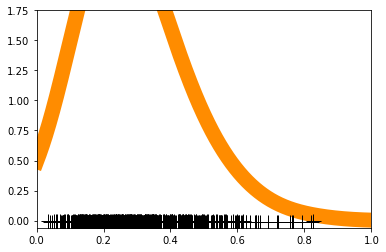

In [ ]:
###############################################################
# Post training and k-fold evaluation on test set starts here #
###############################################################
all_ground_truth_labels = []
all_predicted_labels = []
cfs_scores = []

multi_test_doc_ground_truth_labels = []
multi_test_doc_predicted_labels = []
multi_test_doc_cfs_scores = []

p_at_k_thresholds = [10, 20, 50]

if test_file_path:
    prev_sent_id = -1

    if ".tsv" in test_file_path or ".csv" in test_file_path:
        with open(test_file_path, encoding=test_file_encoding) as test_data_sv:
            test_data = csv.reader(test_data_sv, delimiter=csv_delimiter, quotechar='"')

            if test_file_has_header:
                next(test_data)

            for d in test_data:
                if int(d[0].split(',')[0]) < prev_sent_id and test_file_in_multiple_doc_order:
                    multi_test_doc_ground_truth_labels.append(deepcopy(all_ground_truth_labels))
                    multi_test_doc_predicted_labels.append(deepcopy(all_predicted_labels))
                    multi_test_doc_cfs_scores.append(deepcopy(cfs_scores))

                    all_ground_truth_labels = []
                    all_predicted_labels = []
                    cfs_scores = []
                    prev_sent_id = int(d[0].split(',')[0])
                else:
                    prev_sent_id = int(d[0].split(',')[0])
                
                # Get label probabilities from trained model
                cfs_score = getCFSScore(train_file_name, d[0].split(',')[2])
                sentence_label = int(d[0].split(',')[-2])

                # Aggregate ground truth and predicted labels for each sentence
                all_ground_truth_labels.append(sentence_label)
                all_predicted_labels.append(argmax(cfs_score))

                # Aggregate CFS scores given by model
                cfs_scores.append(cfs_score[1])
            
            if len(multi_test_doc_ground_truth_labels) and len(all_ground_truth_labels):
                multi_test_doc_ground_truth_labels.append(deepcopy(all_ground_truth_labels))
                multi_test_doc_predicted_labels.append(deepcopy(all_predicted_labels))
                multi_test_doc_cfs_scores.append(deepcopy(cfs_scores))
    else:
        with open(test_file_path, encoding=test_file_encoding) as test_data_json:
            test_data = json.load(test_data_json)

            for d in test_data:
                # Get label probabilities from trained model
                cfs_score = getCFSScore(train_file_name, d["text"])
                sentence_label = int(d["label"])

                # Aggregate ground truth and predicted labels for each sentence
                all_ground_truth_labels.append(sentence_label)
                all_predicted_labels.append(argmax(cfs_score))

                # Aggregate CFS scores given by model
                cfs_scores.append(cfs_score[1])

    if len(multi_test_doc_ground_truth_labels) == 0:
        classification_report = mt.classification_report(all_ground_truth_labels, all_predicted_labels, digits=4)
        confusion_matrix = mt.confusion_matrix(all_ground_truth_labels, all_predicted_labels)
        balanced_accuracy = mt.balanced_accuracy_score(all_ground_truth_labels, all_predicted_labels)
        average_precision = compute_average_precision(all_ground_truth_labels, cfs_scores)
        ndcg = compute_ndcg(all_ground_truth_labels, cfs_scores)
        try:
            final_p_at_k = [x[th - 1] for x, th in zip(compute_precisions(all_ground_truth_labels, cfs_scores), p_at_k_thresholds)]
        except IndexError:
            final_p_at_k = "Not enough test samples to calculate precisions at defined thresholds."
    else:
        merged_gt_labels = list(chain.from_iterable(multi_test_doc_ground_truth_labels))
        merged_pred_labels = list(chain.from_iterable(multi_test_doc_predicted_labels))
        classification_report = mt.classification_report(merged_gt_labels, merged_pred_labels, digits=4)
        confusion_matrix = mt.confusion_matrix(merged_gt_labels, merged_pred_labels)

        balanced_accuracy = sum([mt.balanced_accuracy_score(x, y) for x, y in zip(multi_test_doc_ground_truth_labels, multi_test_doc_predicted_labels)]) / len(multi_test_doc_ground_truth_labels)
        average_precision = sum([compute_average_precision(x, y) for x, y in zip(multi_test_doc_ground_truth_labels, multi_test_doc_cfs_scores)]) / len(multi_test_doc_ground_truth_labels)
        ndcg = sum([compute_ndcg(x, y) for x, y in zip(multi_test_doc_ground_truth_labels, multi_test_doc_cfs_scores)]) / len(multi_test_doc_ground_truth_labels)

        final_p_at_k = [0.0] * len(p_at_k_thresholds)
        precisions_at_k_pruned = []
        precisions_at_k = [compute_precisions(x, y) for x, y in zip(multi_test_doc_ground_truth_labels, multi_test_doc_cfs_scores)]
        try:
            for p in precisions_at_k:
                p_th = []

                for th in p_at_k_thresholds:
                    p_th.append(p[th - 1])
                
                precisions_at_k_pruned.append(p_th)

            for i in range(0, len(p_at_k_thresholds)):
                for p in precisions_at_k_pruned:
                    final_p_at_k[i] += p[i]

            final_p_at_k = [x / len(multi_test_doc_ground_truth_labels) for x in final_p_at_k]
        except IndexError:
            final_p_at_k = "Not enough test samples to calculate precisions at defined thresholds."


    print("###### Test Set Classification Report #####\n", classification_report)
    print("######## Test Set Confusion Matrix ########\n", confusion_matrix, "\n")
    print("nDCG Score: ", ndcg)
    print("(Mean) Average Precision: ", average_precision)
    print("Balanced Accuracy: ", balanced_accuracy, "\n")
    print("Average Precision @ k: ", p_at_k_thresholds, final_p_at_k)
    compute_kde(cfs_scores)
